In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from sklearn.manifold import TSNE  # For latent space visualization

# Random Seed for Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Set the device to mps or cuda
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: mps


In [2]:
# Hyperparameters
learning_rate = 0.0005
batch_size = 256
num_epochs = 30
latent_dim = 256
beta = 0.9  # KL divergence scaling factor

# Network architecture
hidden_dims = [512, 256]  # Encoder and decoder hidden layer sizes

# Data augmentation (if any)
data_augmentation = False


In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dims=[512, 256], latent_dim=256):
        super(VAE, self).__init__()
        
        # Encoder
        modules = []
        last_dim = input_dim
        for h_dim in hidden_dims:
            modules.append(nn.Sequential(
                nn.Linear(last_dim, h_dim),
                nn.ReLU()))
            last_dim = h_dim
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        hidden_dims.reverse()
        modules = []
        last_dim = latent_dim
        for h_dim in hidden_dims:
            modules.append(nn.Sequential(
                nn.Linear(last_dim, h_dim),
                nn.ReLU()))
            last_dim = h_dim
        modules.append(nn.Linear(last_dim, input_dim))
        modules.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*modules)
    
    def encode(self, x):
        h = self.encoder(x)
        mu      = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x_recon = self.decoder(z)
        return x_recon
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var


In [5]:
def loss_function(x_recon, x, mu, log_var, beta):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_recon, x.view(-1, 28*28), reduction='sum')
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    # Total loss
    return recon_loss + beta * kld_loss, recon_loss, kld_loss


In [6]:
model = VAE(latent_dim=latent_dim, hidden_dims=hidden_dims).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [7]:
# Lists to keep track of losses
train_loss_list = []
recon_loss_list = []
kld_loss_list = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    recon_loss_epoch = 0
    kld_loss_epoch = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_recon, mu, log_var = model(data)
        loss, recon_loss, kld_loss = loss_function(x_recon, data, mu, log_var, beta)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        recon_loss_epoch += recon_loss.item()
        kld_loss_epoch += kld_loss.item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss_epoch / len(train_loader.dataset)
    avg_kld_loss = kld_loss_epoch / len(train_loader.dataset)
    train_loss_list.append(avg_loss)
    recon_loss_list.append(avg_recon_loss)
    kld_loss_list.append(avg_kld_loss)
    
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KLD Loss: {avg_kld_loss:.4f}')


Epoch 1, Loss: 57.0163, Recon Loss: 55.9860, KLD Loss: 1.1447
Epoch 2, Loss: 48.0648, Recon Loss: 45.7515, KLD Loss: 2.5703
Epoch 3, Loss: 45.1857, Recon Loss: 41.1647, KLD Loss: 4.4677
Epoch 4, Loss: 42.1519, Recon Loss: 36.4598, KLD Loss: 6.3245
Epoch 5, Loss: 40.6973, Recon Loss: 34.1416, KLD Loss: 7.2841
Epoch 6, Loss: 39.6823, Recon Loss: 32.5749, KLD Loss: 7.8972
Epoch 7, Loss: 38.4701, Recon Loss: 30.9386, KLD Loss: 8.3684
Epoch 8, Loss: 36.6305, Recon Loss: 28.9021, KLD Loss: 8.5871
Epoch 9, Loss: 35.0612, Recon Loss: 27.1078, KLD Loss: 8.8370
Epoch 10, Loss: 33.6213, Recon Loss: 25.4053, KLD Loss: 9.1289
Epoch 11, Loss: 32.5323, Recon Loss: 24.0612, KLD Loss: 9.4123
Epoch 12, Loss: 31.8105, Recon Loss: 23.1756, KLD Loss: 9.5944
Epoch 13, Loss: 31.2404, Recon Loss: 22.4051, KLD Loss: 9.8170
Epoch 14, Loss: 30.6347, Recon Loss: 21.6622, KLD Loss: 9.9695
Epoch 15, Loss: 30.2342, Recon Loss: 21.1493, KLD Loss: 10.0943
Epoch 16, Loss: 29.9123, Recon Loss: 20.7119, KLD Loss: 10.2227

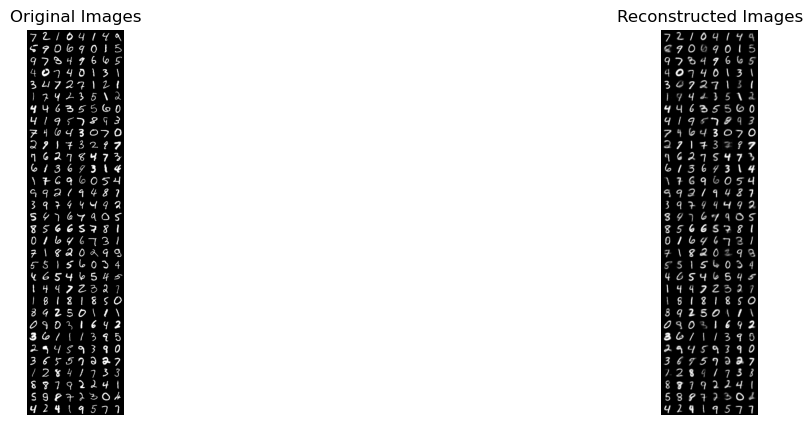

In [8]:
# Get a batch of test data
model.eval()
with torch.no_grad():
    test_data, _ = next(iter(test_loader))
    test_data = test_data.to(device)
    x_recon, _, _ = model(test_data)
    x_recon = x_recon.view(-1, 1, 28, 28).cpu()
    
# Original images
grid_original = torchvision.utils.make_grid(test_data.cpu(), nrow=8, normalize=True)
# Reconstructed images
grid_recon = torchvision.utils.make_grid(x_recon, nrow=8, normalize=True)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(np.transpose(grid_original, (1, 2, 0)))
axs[0].set_title('Original Images')
axs[0].axis('off')

axs[1].imshow(np.transpose(grid_recon, (1, 2, 0)))
axs[1].set_title('Reconstructed Images')
axs[1].axis('off')

plt.show()


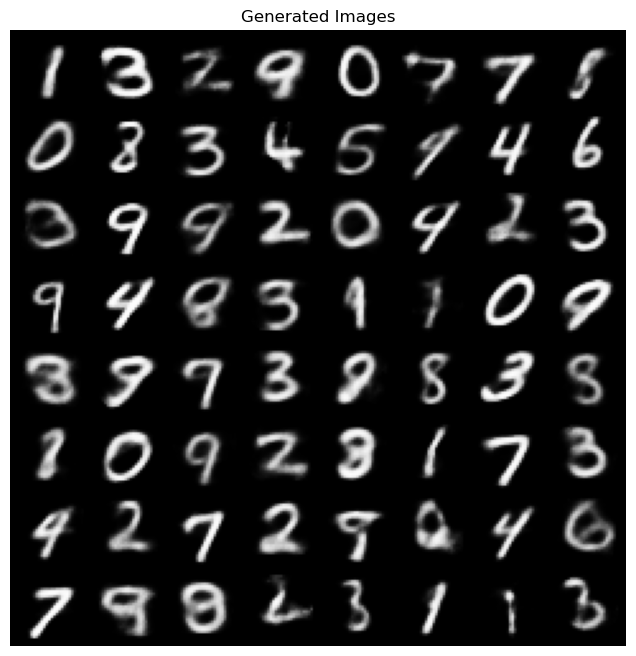

In [9]:
# Sample from the latent space
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z)
    sample = sample.view(-1, 1, 28, 28).cpu()

# Plot the generated images
grid_sample = torchvision.utils.make_grid(sample, nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid_sample, (1, 2, 0)))
plt.title('Generated Images')
plt.axis('off')
plt.show()


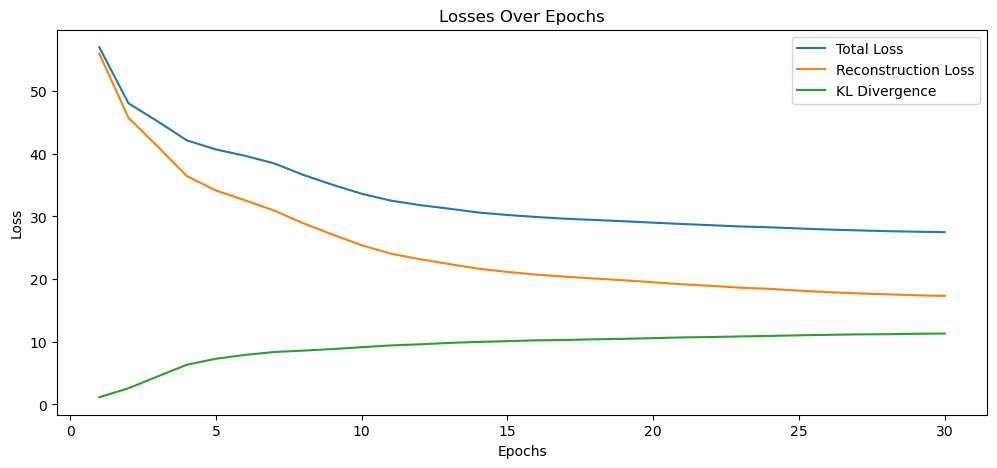

In [10]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.plot(epochs, train_loss_list, label='Total Loss')
plt.plot(epochs, recon_loss_list, label='Reconstruction Loss')
plt.plot(epochs, kld_loss_list, label='KL Divergence')
plt.title('Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# Function to add noise to images
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
    return noisy_imgs

# Create a set of anomalous images
anomalous_data = add_noise(test_data)


In [12]:
# Compute reconstruction error for normal and anomalous images
def compute_reconstruction_error(data_loader, model):
    model.eval()
    recon_errors = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            x_recon, _, _ = model(data)
            loss = nn.functional.mse_loss(x_recon, data.view(-1, 28*28), reduction='none')
            loss = loss.sum(dim=1)
            recon_errors.extend(loss.cpu().numpy())
    return recon_errors

# Reconstruction error for normal test images
normal_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
normal_recon_errors = compute_reconstruction_error(normal_loader, model)

# Reconstruction error for anomalous images
anomalous_dataset = torch.utils.data.TensorDataset(anomalous_data.cpu(), torch.zeros(len(anomalous_data)))
anomalous_loader = DataLoader(anomalous_dataset, batch_size=batch_size, shuffle=False)
anomalous_recon_errors = compute_reconstruction_error(anomalous_loader, model)


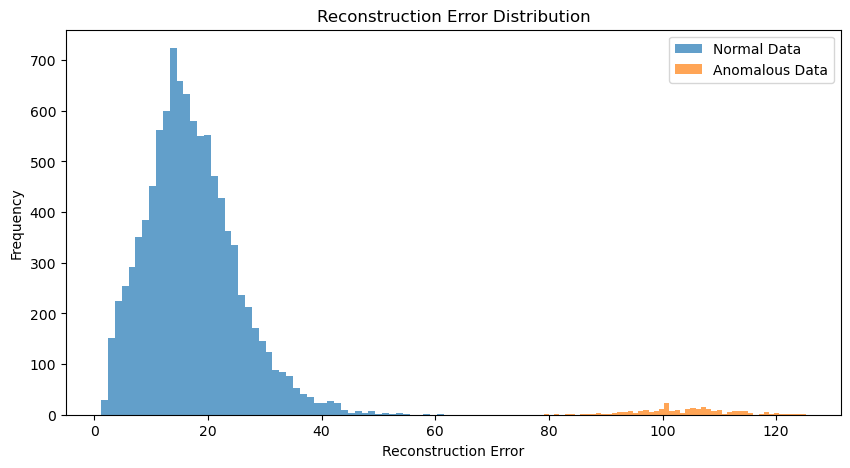

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(normal_recon_errors, bins=50, alpha=0.7, label='Normal Data')
plt.hist(anomalous_recon_errors, bins=50, alpha=0.7, label='Anomalous Data')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [14]:
# Combine errors and labels
errors = normal_recon_errors + anomalous_recon_errors
labels = np.hstack((np.zeros(len(normal_recon_errors)), np.ones(len(anomalous_recon_errors))))

# Set threshold (e.g., mean + 2*std of normal errors)
threshold = np.mean(normal_recon_errors) + 2 * np.std(normal_recon_errors)
print(f"Threshold for anomaly detection: {threshold:.4f}")

# Predict anomalies
predictions = np.array(errors) > threshold

# Compute accuracy
accuracy = (predictions == labels).mean()
print(f"Anomaly Detection Accuracy: {accuracy * 100:.2f}%")


Threshold for anomaly detection: 33.0850
Anomaly Detection Accuracy: 96.18%


In [15]:
# Collect latent vectors and labels from the test dataset
latent_vectors = []
labels = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, 28*28))
        latent_vectors.append(mu.cpu().numpy())
        labels.extend(target.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.array(labels)


In [16]:
from sklearn.manifold import TSNE

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=seed)
latent_2d = tsne.fit_transform(latent_vectors)


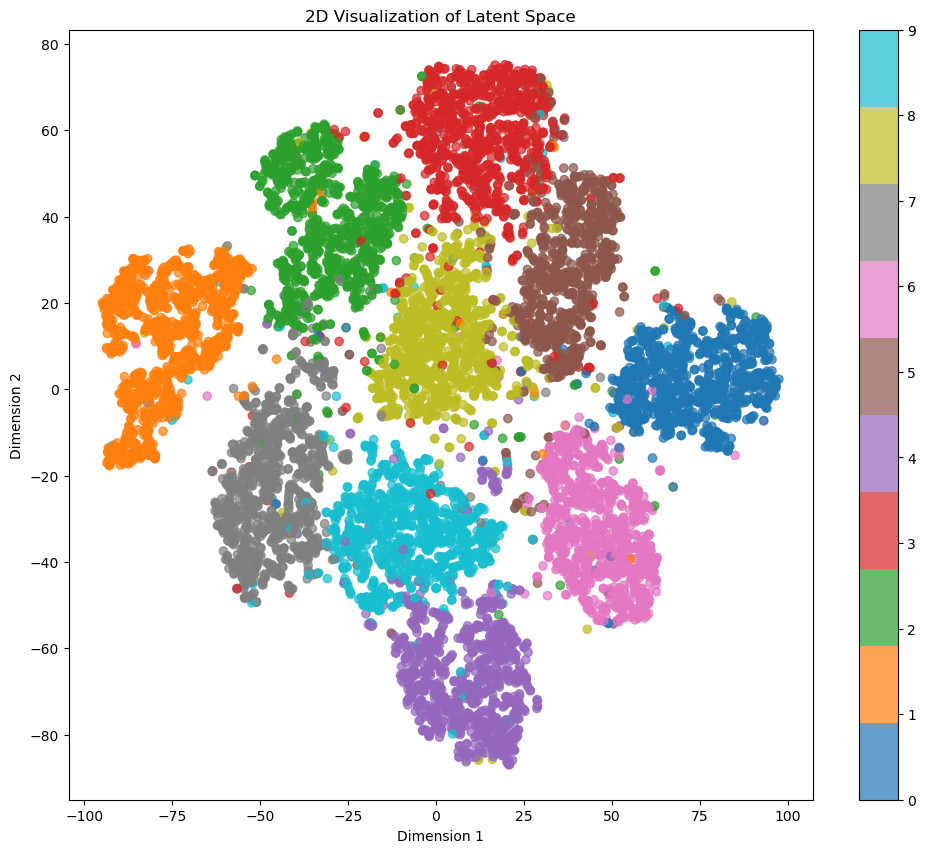

In [17]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title('2D Visualization of Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
